https://contest.yandex.ru/contest/48440/problems/?nc=gfhguN62

## [Imports](#Imports_)
## [Globals](#Globals_)
## [Setup](#Setup_)
## [Data](#Data_)

## Imports <span id=Imports_></span>

In [452]:
%load_ext nb_black

import catboost
import dataclasses
import datetime
import functools
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import torch
import typing as tp
import warnings

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Globals <span id=Globals_></span>

In [5]:
COMPETITION = "demand-forecasting-kernels-only"

X_type = tp.NewType("X_type", np.ndarray)
X_row_type = tp.NewType("X_row_type", np.ndarray)
Y_type = tp.NewType("Y_type", np.array)
TS_type = tp.NewType("TS_type", pd.Series)
Model_type = tp.TypeVar("Model_type")

<IPython.core.display.Javascript object>

## Setup <span id=Setup_></span>

### Notebook

In [6]:
def make_new_markdown_section_with_link(section, header="##", do_print=True):
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header


def make_several_sections(section_names=("Setup", "Imports", "Data")):
    links, headers = zip(
        *[
            make_new_markdown_section_with_link(sn, do_print=False)
            for sn in section_names
        ]
    )
    print("\n".join(links + ("",) + headers))

<IPython.core.display.Javascript object>

### Terminal

In [12]:
def mkdir(path, error_if_exists=False):
    !mkdir {"-p" if not error_if_exists else ""} {path}


def unzip(zip_path, save_path=None, delete_zip=False):
    !unzip {zip_path} {"-d "+ save_path if save_path else ""}
    if delete_zip:
        for path in glob.glob(zip_path):
            if path.endswith(".zip"):
                !trash {path}


def unzip_to_data_and_delete():
    unzip("data/*", "data", delete_zip=True)

<IPython.core.display.Javascript object>

### Kaggle

In [8]:
def kaggle_competitions_search(search_term):
    !kaggle competitions list -s {search_term}


def kaggle_competitions_files(competition):
    !kaggle competitions files {competition}


def kaggle_competitions_download(competition, save_path="data", filename=None):
    mkdir(save_path)
    !kaggle competitions download -p {save_path} {"-f " + filename if filename else ""} {competition}


def kaggle_competitions_submit(competition, filename, message="submit"):
    !kaggle competitions submit -f {filename} -m {message} {competition}


def kaggle_competitions_submissions(competition):
    !kaggle competitions submissions {competition}

<IPython.core.display.Javascript object>

In [9]:
kaggle_competitions_files(COMPETITION)

name                    size  creationDate         
---------------------  -----  -------------------  
train.csv               17MB  2019-12-15 20:53:53  
test.csv               952KB  2019-12-15 20:53:53  
sample_submission.csv  385KB  2019-12-15 20:53:53  


<IPython.core.display.Javascript object>

In [59]:
kaggle_competitions_download(COMPETITION)

100%|██████████████████████████████████████| 3.29M/3.29M [00:00<00:00, 8.37MB/s]
100%|██████████████████████████████████████| 3.29M/3.29M [00:00<00:00, 7.12MB/s]


<IPython.core.display.Javascript object>

In [ ]:
unzip_to_data_and_delete()

## Data <span id=Data_></span>

In [885]:
def extract_hybrid_strategy_features(
    timeseries: TS_type,
    model_idx: int,
    window_size: int = 7,
) -> X_row_type:
    """
    Функция для получения вектора фичей согласно гибридной схеме. На вход подаётся временной ряд
    до момента T, функция выделяет из него фичи, необходимые модели под номером model_idx для
    прогноза на момент времени T

    Args:
        timeseries --- временной ряд до момента времени T (не включительно), pd.Series с датой
                       в качестве индекса
        model_idx --- индекс модели, то есть номер шага прогноза,
                      для которого нужно получить признаки, нумерация с нуля
        window_size --- количество последних значений ряда, используемых для прогноза
                        (без учёта количества прогнозов с предыдущих этапов)

    Returns:
        Одномерный вектор фичей для модели с индексом model_idx (np.array),
        чтобы сделать прогноз для момента времени T
    """
    # YOUR CODE HERE
    return timeseries[-(window_size + model_idx) :].values

<IPython.core.display.Javascript object>

In [974]:
# import dataclasses
# import datetime
import numpy as np
import pandas as pd
import sklearn
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import typing as tp

# import warnings

X_type = tp.NewType("X_type", np.ndarray)
X_row_type = tp.NewType("X_row_type", np.ndarray)
Y_type = tp.NewType("Y_type", np.array)
TS_type = tp.NewType("TS_type", pd.Series)
Model_type = tp.TypeVar("Model_type")


def read_timeseries(path_to_df: str = "data/train.csv") -> TS_type:
    """Функция для чтения данных и получения обучающей и тестовой выборок"""
    df = pd.read_csv(path_to_df)
    df = df[(df["store"] == 1) & (df["item"] == 1)]
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date")
    ts = df["sales"]
    train_ts = ts[:-365]
    test_ts = ts[-365:]
    return train_ts, test_ts


def extract_hybrid_strategy_features(
    timeseries: TS_type,
    model_idx: int,
    window_size: int = 7,
) -> X_row_type:
    """
    Функция для получения вектора фичей согласно гибридной схеме. На вход подаётся временной ряд
    до момента T, функция выделяет из него фичи, необходимые модели под номером model_idx для
    прогноза на момент времени T

    Args:
        timeseries --- временной ряд до момента времени T (не включительно), pd.Series с датой
                       в качестве индекса
        model_idx --- индекс модели, то есть номер шага прогноза,
                      для которого нужно получить признаки, нумерация с нуля
        window_size --- количество последних значений ряда, используемых для прогноза
                        (без учёта количества прогнозов с предыдущих этапов)

    Returns:
        Одномерный вектор фичей для модели с индексом model_idx (np.array),
        чтобы сделать прогноз для момента времени T
    """
    # YOUR CODE HERE
    return timeseries[-(window_size + model_idx) :].values


class FeatureExtractor:
    def __init__(
        self,
        timeseries: TS_type,
        model_idx: int,
        day_window_size: int = 6,
        week_window_size: int = 3,
        month_window_size: int = 11,
        year_window_size: int = 3,
    ):
        self.timeseries = timeseries
        self.model_idx = model_idx
        self.day_window_size = day_window_size
        self.week_window_size = week_window_size
        self.month_window_size = month_window_size
        self.year_window_size = year_window_size

        self.now_timestamp = self.timeseries.index[-1]
        self.prediction_timestamp = self.now_timestamp + pd.Timedelta(
            days=self.model_idx + 1
        )
        self.mean = self.timeseries.mean()

    def get_period_features(self, index):
        index = [i for i in index if i <= self.now_timestamp]
        period_features = self.timeseries.reindex(index)
        mean = period_features.mean()
        if np.isnan(mean):
            mean = self.mean
        period_features = period_features.fillna(mean)
        return period_features.values

    def get_period_features_for_period(self, days_in_period, window_size):
        index = [
            self.prediction_timestamp - pd.Timedelta(days=i * days_in_period)
            for i in range(1, window_size + 1)
        ]
        return self.get_period_features(index)

    def extract_features(self):
        features = []
        features.extend(
            self.get_period_features_for_period(
                days_in_period=1, window_size=self.day_window_size
            )
        )
        features.extend(
            self.get_period_features_for_period(
                days_in_period=7, window_size=self.week_window_size
            )
        )
        features.extend(
            self.get_period_features_for_period(
                days_in_period=30, window_size=self.month_window_size
            )
        )
        features.extend(
            self.get_period_features_for_period(
                days_in_period=365, window_size=self.year_window_size
            )
        )

        return np.stack(features)


def my_extract_features(*args, **kwargs):
    return FeatureExtractor(*args, **kwargs).extract_features()


def build_datasets(
    timeseries: TS_type,
    extract_features: tp.Callable[..., X_row_type] = extract_hybrid_strategy_features,
    window_size: int = 6,
    model_count: int = 1,
) -> tp.List[tp.Tuple[X_type, Y_type]]:
    """
    Функция для получения обучающих датасетов согласно гибридной схеме

    Args:
        timeseries --- временной ряд
        extract_features --- функция для генерации вектора фичей
        window_size --- количество последних значений ряда, используемых для прогноза
        model_count --- количество моделей, используемых для получения предскзаний

    Returns:
        Список из model_count датасетов, i-й датасет используется для обучения i-й модели
        и представляет собой пару из двумерного массива фичей и одномерного массива таргетов
    """
    datasets = []
    # YOUR CODE HERE
    for model_idx in range(model_count):
        offset_timeseries = timeseries[window_size + model_idx :]
        y = offset_timeseries.values
        x = []
        for pred_time in offset_timeseries.index:
            x.append(
                extract_features(
                    timeseries[: pred_time - pd.Timedelta(days=1)],
                    model_idx,
                    window_size,
                )
            )
        x = np.stack(x)
        datasets.append((x, y))

    assert len(datasets) == model_count
    return datasets


def my_build_datasets(
    timeseries: TS_type,
    extract_features: tp.Callable[..., X_row_type] = my_extract_features,
    window_size: int = 6,
    model_count: int = 1,
) -> tp.List[tp.Tuple[X_type, Y_type]]:
    """
    Функция для получения обучающих датасетов согласно гибридной схеме

    Args:
        timeseries --- временной ряд
        extract_features --- функция для генерации вектора фичей
        window_size --- количество последних значений ряда, используемых для прогноза
        model_count --- количество моделей, используемых для получения предскзаний

    Returns:
        Список из model_count датасетов, i-й датасет используется для обучения i-й модели
        и представляет собой пару из двумерного массива фичей и одномерного массива таргетов
    """
    datasets = []
    # YOUR CODE HERE
    for model_idx in range(model_count):
        offset_timeseries = timeseries[window_size + model_idx + 366 :]
        y = offset_timeseries.values
        timedelta = pd.Timedelta(days=1 + model_idx)
        x = []
        for pred_time in offset_timeseries.index:
            x.append(extract_features(timeseries[: pred_time - timedelta], model_idx))
        x = np.stack(x)
        datasets.append((x, y))

    assert len(datasets) == model_count
    return datasets


def predict(
    timeseries: TS_type,
    models: tp.List[Model_type],
    extract_features: tp.Callable[..., X_row_type] = my_extract_features,
) -> TS_type:
    """
    Функция для получения прогноза len(models) следующих значений временного ряда

    Args:
        timeseries --- временной ряд, по которому необходимо сделать прогноз на следующие даты
        models --- список обученных моделей, i-я модель используется для получения i-го прогноза
        extract_features --- функция для генерации вектора фичей. Если вы реализуете свою функцию
                             извлечения фичей для конечной модели, передавайте этим аргументом.
                             Внутри функции predict функцию extract_features нужно вызывать только
                             с аргументами timeseries и model_idx, остальные должны быть со значениями
                             по умолчанию

    Returns:
        Прогноз len(models) следующих значений временного ряда
    """
    if extract_features == my_extract_features:
        features = [
            extract_features(timeseries, model_idx) for model_idx in range(len(models))
        ]
        return [
            model.predict(feats.reshape(1, -1))
            for model, feats in zip(models, features)
        ]
    preds = []
    for model_idx, model in enumerate(models):
        feats = extract_features(timeseries, model_idx)
        pred = model.predict(feats.reshape(1, -1)).item()
        timeseries = timeseries.append(
            pd.Series({timeseries.index[-1] + pd.Timedelta(days=1): pred})
        )
        preds.append(pred)
    return preds


class ForecastingModel:
    def train(self, x: X_type, y: Y_type):
        raise NotImplementedError

    def predict(self, X_row_type):
        raise NotImplementedError


class LinearRegressionForecastingModel:
    def __init__(self):
        self.model = sklearn.linear_model.LinearRegression()

    def train(self, x: X_type, y: Y_type):
        self.x = x
        self.y = y
        self.model.fit(x, y)

    def predict(self, x_row: X_row_type):
        return self.model.predict(x_row)


def get_model() -> ForecastingModel:
    return LinearRegressionForecastingModel()


def train_models(train_timeseries: TS_type, model_count: int) -> tp.List[Model_type]:
    """
    Функция для получения обученных моделей

    Args:
        train_timeseries --- обучающий временной ряд
        model_count --- количество моделей для обучения согласно гибридной схеме.
                        Прогнозирование должно выполняться на model_count дней вперёд

    Returns:
        Список из len(datasets) обученных моделей
    """
    models = []

    # YOUR CODE HERE
    datasets = my_build_datasets(
        train_timeseries,
        window_size=7,
        model_count=model_count,
    )
    for dataset in datasets:
        model = get_model()
        model.train(*dataset)
        models.append(model)

    assert len(models) == len(datasets)
    return models


def score_models(
    train_ts: TS_type,
    test_ts: TS_type,
    models: tp.List[Model_type],
    predict: tp.Callable[[TS_type, tp.List[Model_type]], TS_type] = predict,
):
    """
    Функция для оценки качества обученных моделей по метрике MSE

    Args:
        train_ts --- обучающий временной ряд
        test_ts --- тестовый временной ряд
        models --- список обученных моделей
        predict --- функция для получения прогноза временного ряда

    Returns:
        Усредненное MSE для прогноза моделей по всей тестовой выборке
    """
    predict_len = len(models)
    predictions = []
    targets = []

    for i in range(len(test_ts) - predict_len + 1):
        predictions.extend(list(predict(train_ts, models)))
        targets.extend(list(test_ts[i : i + predict_len]))
        #         with warnings.catch_warnings():
        train_ts = train_ts.append(test_ts[i : i + 1])

    return sklearn.metrics.mean_squared_error(targets, predictions)

<IPython.core.display.Javascript object>

In [975]:
def score(models_count=30):
    train_ts, test_ts = read_timeseries()
    models = train_models(train_ts, models_count)
    return score_models(train_ts, test_ts, models)

<IPython.core.display.Javascript object>

In [976]:
class FeatureExtractor:
    def __init__(
        self,
        timeseries: TS_type,
        model_idx: int,
        day_window_size: int = 6,
        week_window_size: int = 3,
        month_window_size: int = 11,
        year_window_size: int = 3,
    ):
        self.timeseries = timeseries
        self.model_idx = model_idx
        self.day_window_size = day_window_size
        self.week_window_size = week_window_size
        self.month_window_size = month_window_size
        self.year_window_size = year_window_size

        self.now_timestamp = self.timeseries.index[-1]
        self.prediction_timestamp = self.now_timestamp + pd.Timedelta(
            days=self.model_idx + 1
        )
        self.mean = self.timeseries.mean()

    def get_period_features(self, index):
        index = [i for i in index if i <= self.now_timestamp]
        period_features = self.timeseries.reindex(index)
        mean = period_features.mean()
        if np.isnan(mean):
            mean = self.mean
        period_features = period_features.fillna(mean)
        return period_features.values

    def get_period_features_for_period(self, days_in_period, window_size):
        index = [
            self.prediction_timestamp - pd.Timedelta(days=i * days_in_period)
            for i in range(1, window_size + 1)
        ]
        return self.get_period_features(index)

    def extract_features(self):
        features = []
        features.extend(
            self.get_period_features_for_period(
                days_in_period=1, window_size=self.day_window_size
            )
        )
        features.extend(
            self.get_period_features_for_period(
                days_in_period=7, window_size=self.week_window_size
            )
        )
        features.extend(
            self.get_period_features_for_period(
                days_in_period=30, window_size=self.month_window_size
            )
        )
        features.extend(
            self.get_period_features_for_period(
                days_in_period=365, window_size=self.year_window_size
            )
        )

        return np.stack(features)

<IPython.core.display.Javascript object>

In [871]:
%%time
score(30)

CPU times: user 1min 31s, sys: 611 ms, total: 1min 32s
Wall time: 1min 31s


30.75619213181053

<IPython.core.display.Javascript object>

In [ ]:
model_count = 5
models = []

# YOUR CODE HERE
datasets = build_datasets(
    train_ts,
    extract_features=extract_hybrid_strategy_features,
    window_size=7,
    model_count=model_count,
)
for dataset in datasets:
    model = get_model()
    model.train(*dataset)
    models.append(model)

In [747]:
train_ts, test_ts = read_timeseries()
predict_len = len(models)
predictions = []
targets = []

for i in range(len(test_ts) - predict_len + 1):
    predictions.extend(list(predict(train_ts, models)))
    targets.extend(list(test_ts[i : i + predict_len]))
    with warnings.catch_warnings():
        train_ts = train_ts.append(test_ts[i : i + 1])

<IPython.core.display.Javascript object>

In [748]:
sklearn.metrics.mean_squared_error(targets, predictions)

39.59069524748229

<IPython.core.display.Javascript object>

In [703]:
class ConstForecastingModel:
    def train(self, x: X_type, y: Y_type):
        pass

    def __call__(self, x_row: X_row_type):
        return x_row[-1]

<IPython.core.display.Javascript object>

In [717]:
class LinearRegressionForecastingModel:
    def __init__(self):
        self.model = sklearn.linear_model.LinearRegression()

    def train(self, x: X_type, y: Y_type):
        self.model.fit(x, y)

    def __call__(self, x_row: X_row_type):
        return self.model.predict(x_row.reshape(1, -1))

<IPython.core.display.Javascript object>

In [718]:
get_model = lambda: LinearRegressionForecastingModel()
train_ts, test_ts = read_timeseries()
models = train_models(train_ts, 5)
score_models(train_ts, test_ts, models)

39.41401515173336

<IPython.core.display.Javascript object>

In [763]:
get_model = lambda: LinearRegressionForecastingModel()
score()

44.37568568822863

<IPython.core.display.Javascript object>

In [ ]:
datasets = build_datasets(
    train_ts,
    extract_features=extract_hybrid_strategy_features,
    window_size=7,
    model_count=3,
)

In [706]:
class GradientBoostingRegressorForecastingModel:
    def __init__(self):
        self.model = sklearn.ensemble.GradientBoostingRegressor()

    def train(self, x: X_type, y: Y_type):
        self.model.fit(x, y)

    def __call__(self, x_row: X_row_type):
        return self.model.predict(x_row.reshape(1, -1))

<IPython.core.display.Javascript object>

In [707]:
get_model = lambda: GradientBoostingRegressorForecastingModel()
score()

42.34308954683096

<IPython.core.display.Javascript object>

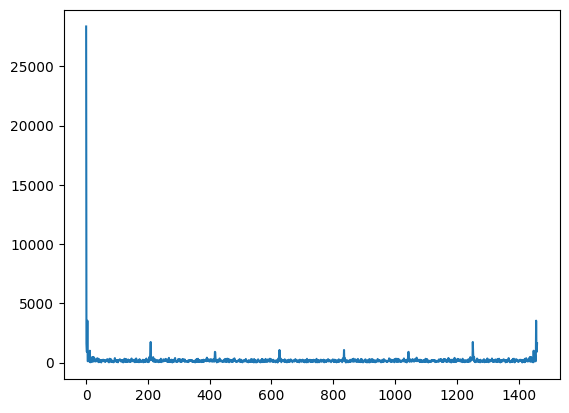

<IPython.core.display.Javascript object>

In [328]:
import scipy

ft = scipy.fft.fft(train_ts.values)
plt.plot(np.abs(ft))

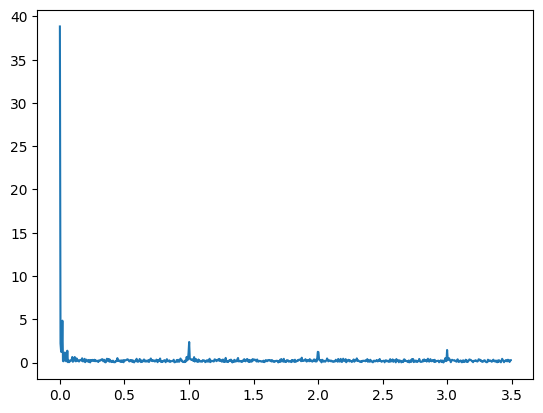

<IPython.core.display.Javascript object>

In [732]:
N = len(train_ts)
T = 1 / 7
xf = scipy.fft.fftfreq(N, T)[: N // 2]
yf = scipy.fft.fft(train_ts.values)
plt.plot(xf, 2.0 / N * np.abs(yf[0 : N // 2]))

<Axes: xlabel='date'>

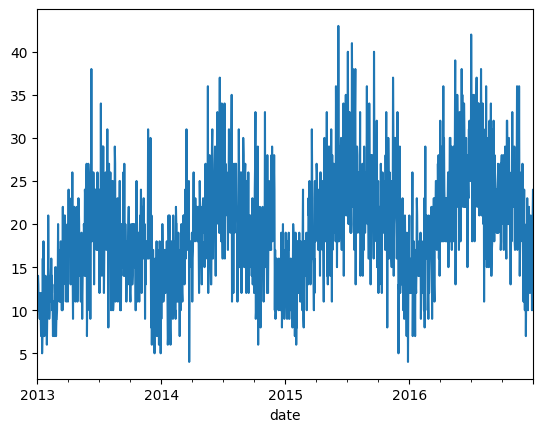

<IPython.core.display.Javascript object>

In [322]:
train_ts.plot()

In [245]:
get_model = lambda: LinearRegressionForecastingModel()
preprocess_timeseries = my_preprocess_timeseries
score(window_size=5)

57.00369446940426

<IPython.core.display.Javascript object>

In [168]:
get_model = lambda: GradientBoostingRegressorForecastingModel()
score(window_size=5)

43.52195474906381

<IPython.core.display.Javascript object>

In [170]:
class CatBoostRegressorForecastingModel:
    def __init__(self):
        self.model = catboost.CatBoostRegressor()

    def train(self, x: X_type, y: Y_type):
        self.model.fit(x, y, verbose=False)

    def __call__(self, x_row: X_row_type):
        return self.model.predict(x_row.reshape(1, -1))

<IPython.core.display.Javascript object>

In [171]:
get_model = lambda: CatBoostRegressorForecastingModel()
score(window_size=5)

44.99069938110541

<IPython.core.display.Javascript object>

In [212]:
df

,sales,weekday,day,month,dayofyear,year
0,13,1,1,1,1,2013
1,11,2,2,1,2,2013
2,14,3,3,1,3,2013
3,13,4,4,1,4,2013
4,10,5,5,1,5,2013
...,...,...,...,...,...,...
1456,10,1,27,12,362,2016
1457,16,2,28,12,363,2016
1458,21,3,29,12,364,2016
1459,24,4,30,12,365,2016


<IPython.core.display.Javascript object>